# Project 7: Implement a scoring model.

*Pierre-Eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.

In [1]:
# File system management
import os

# Get execution time to compare models
import time

# Import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams.update({'axes.edgecolor': 'white',
                     'axes.facecolor': 'white',
                     'axes.linewidth': 2.0,
                     'figure.facecolor': 'white'})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get all functions required to prepare data
from functions.preprocessing import *
from functions.modeling import *

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare the data</a></span><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Transform-data" data-toc-modified-id="Transform-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Transform data</a></span></li></ul></li><li><span><a href="#Shortlist-Promising-Models" data-toc-modified-id="Shortlist-Promising-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shortlist Promising Models</a></span><ul class="toc-item"><li><span><a href="#Select-a-Performance-Measure" data-toc-modified-id="Select-a-Performance-Measure-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Select a Performance Measure</a></span></li><li><span><a href="#Establish-a-performance-baseline-with-a-dummy-classifier" data-toc-modified-id="Establish-a-performance-baseline-with-a-dummy-classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Establish a performance baseline with a dummy classifier</a></span></li><li><span><a href="#Train-quick-and-dirty-models-and-compare-their-performance" data-toc-modified-id="Train-quick-and-dirty-models-and-compare-their-performance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train quick and dirty models and compare their performance</a></span></li><li><span><a href="#Data-augmentation-with-SMOTE" data-toc-modified-id="Data-augmentation-with-SMOTE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data augmentation with SMOTE</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Feature Selection</a></span></li></ul></li><li><span><a href="#Fine-Tune-the-hyperparameters" data-toc-modified-id="Fine-Tune-the-hyperparameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fine-Tune the hyperparameters</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></li><li><span><a href="#Analyse-feature-importance-with-SHAP" data-toc-modified-id="Analyse-feature-importance-with-SHAP-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse feature importance with SHAP</a></span></li></ul></div>

## Prepare the data

### Read in data

In [2]:
list_files = sorted(os.listdir("data/"), key=str.lower)
for i, file in enumerate(list_files):
    print("{}) {}".format(i+1, file))

app_test = pd.read_csv("data/" + list_files[0])
app_train = pd.read_csv("data/" + list_files[1])
bureau =  pd.read_csv("data/" + list_files[2])
b_b = pd.read_csv("data/" + list_files[3])
cc_balance = pd.read_csv("data/" + list_files[4])
ins_payments = pd.read_csv("data/" + list_files[6])
pos_cash = pd.read_csv("data/" + list_files[7])
prev_app = pd.read_csv("data/" + list_files[8])

1) application_test.csv
2) application_train.csv
3) bureau.csv
4) bureau_balance.csv
5) credit_card_balance.csv
6) HomeCredit_columns_description.csv
7) installments_payments.csv
8) POS_CASH_balance.csv
9) previous_application.csv
10) sample_submission.csv


### Transform data

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:
# Drop the target and the ID of input data
X = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)

# Get the categorical attributes
cat_att = list(X.select_dtypes('object'))

# Get the values to fill missing values
values = drop_na_att(X[cat_att]).value_counts().index[0]

# Get the numerical attributes
num_att = list(X.select_dtypes(['int', 'float']))
ord_att = list(X[num_att].loc[:, X[num_att].nunique()<6])
sparse_att = [c for c in num_att
              if c not in ord_att
              and (X[c]==0).sum() > 0.5*len(X)]
dense_att = [c for c in num_att
             if c not in ord_att
             and c not in sparse_att]
filtered_dense_att = list(drop_na_att(X[dense_att])) + ['DAYS_EMPLOYED_ANOM']

# Create a pipeline with an encoder
# drop the first category in each feature with two categories (drop='if_binary')
cat_pipeline = Pipeline([
               ('filter', FunctionTransformer(drop_na_att)),               
               ('imputer', FunctionTransformer(impute_cat_att,
                                               kw_args={'values': values})),
               ('encoder', OneHotEncoder(drop='if_binary')),
               ])

# Pipeline to prepare numerical ordinal features
ord_pipeline = Pipeline([
               ('filter', FunctionTransformer(drop_na_att)),
               ('imputer', SimpleImputer(strategy='most_frequent')),
               ])

# Pipeline to prepare sparse features with at least 6 distinct values
sparse_pipeline = Pipeline([
                  ('filter', FunctionTransformer(drop_na_att)),
                  ('cleaner', FunctionTransformer(fix_sparse_anomalies)),
                  ('imputer', SimpleImputer(strategy='most_frequent')),
                  ('scaler', MaxAbsScaler())
                  ])

# Pipeline to prepare dense features with at least 6 distinct values
dense_pipeline = Pipeline([
                 ('filter', FunctionTransformer(drop_na_att)),
                 ('cleaner', FunctionTransformer(fix_dense_anomalies)),
                 ('imputer', SimpleImputer()),
                 ('poly_adder', FunctionTransformer(add_polynomial_att,
                                                    kw_args={'names': filtered_dense_att})),
                 ('domain_adder', FunctionTransformer(add_domain_att)),
                 ('skew_transformer', FunctionTransformer(tr_skew_att)),
                 ('scaler', StandardScaler())
                 ])

# Pipeline to prepare all data
full_pipeline = ColumnTransformer([
                ('cat', cat_pipeline, cat_att),
                ('ordinal', ord_pipeline, ord_att),
                ('sparse', sparse_pipeline, sparse_att),
                ('dense', dense_pipeline, dense_att),
                ])

In [ ]:
# Prepare data
y_train = app_train['TARGET']
X_train = full_pipeline.fit_transform(X)

# Get the name of onehot encoded features
onehot_att = list(drop_na_att(X[cat_att]))
encoder = OneHotEncoder(drop='if_binary')
encoder.fit(impute_cat_att(X[onehot_att], values=values))
onehot_att = list(encoder.get_feature_names(onehot_att))
# Get the name of polynomial attributes
poly_att = ['EXT_SOURCE_2', 'EXT_SOURCE_3']
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_transformer.fit(X[poly_att].fillna(X[poly_att].mean()))
n = len(poly_att)
poly_att = poly_transformer.get_feature_names(input_features=poly_att)[n:]
# Get the name of domain attributes
domain_att = ['DAYS_EMPLOYED_PERC', 'CREDIT_INCOME_PERC', 'INCOME_PER_PERSON',
              'ANNUITY_INCOME_PERC', 'CREDIT_TERM']
# Get the name of all attributes
extra_att = ['DAYS_EMPLOYED_ANOM'] + poly_att + domain_att
att = onehot_att + list(drop_na_att(X[num_att])) + extra_att

df_train = pd.DataFrame(X_train, columns=att)
df_train.head()

## Shortlist Promising Models

### Select a Performance Measure

In [6]:
print(f"Percentage of the positive class: \
{app_train['TARGET'].value_counts()[1]/len(app_train):.1%}")

Percentage of the positive class: 8.1%


Though *accuracy* is generally the first performance used for binary classification, it is seldom the best choice when we are dealing with *skewed dataset*, like the one we have.  
To prove it, let's take a very dumb classifier that just classifies every instance in the *negative* class (meaning the majority class). We would get an accuracy of $92\%$, not bad for such dumb classifier! Thus, no matter the model used, the accuracy will be high. It will be difficult to know if our model really learn something, whether it has skill on the dataset.

There are much better way to evaluate the performance of a classifier, all depends on the model's objective. Let's remind ourselves the objective: **predict whether a new client will be in default or not.** It will cost much more money for the bank to grant a loan to a person that will be not able to repay it, than the opposite, refuse to approve a loan for someone who could pay it back. Meaning we care more about *False Negative* than *False Positive*, in other words, whe prefer having a high *Recall* than a high *Precision*.

The $F_1$ score is often used for imbalanced data and binary classification problems. It is the *harmonic mean* of *Precision* and *Recall*:

$\displaystyle F_1 = 2 \times \frac {precision \times recall}{precision + recall}$

The $F_1$ score favors classifiers that have similar *precision* and *recall*. As said above, this is not what we want. Then, we will use another score typically used for such problem: the *AUC* score. AUC standing for "Area Under the Curve". Two curves can be used to compute the AUC:
- the Precision-Recall (PR) curve
- the Receiver Operating Characteristic (ROC) curve

The former is prefered when:
- the positive class is rare or,
- you care more about the false positives than the false negative.

Here, we definitely care more about the false negatives than false postives, but the dataset is severely imbalanced with the positive class as the minority one. So we should use the PR curve. However, as we will see in the next section, we will use a technique named SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class, and as we are more concern by the recall than the precision, **we will compute the ROC AUC.**

### Establish a performance baseline with a dummy classifier

A performance baseline provides a minimum score above which a model is considered to have skill on the dataset. It provides a line by which all other algorithms can be compared. A baseline can be established using a naive classifier, such as predicting the most frequent class label for all examples in the dataset.

Each metric requires the careful choice of a specific naive classification strategy that achieves the appropriate "*no skill*" performance. A no-skill model has a ROC AUC of 0.5 and can be achieved by predicting class labels randomly, while respecting the training set's class distribution (e.g. 8.1% for the positive class).  
We will use the "*stratified*" strategy of the sklearn class `DummyClassifier`.

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Train a dummy classifier
dummy_clf = DummyClassifier(strategy='stratified')

# Get the ROC AUC
cv = StratifiedKFold(5, shuffle=True, random_state=42)
dummy_scores = cross_val_score(dummy_clf, X_train, y_train,
                               scoring='roc_auc', cv=cv, n_jobs=1)
print(f"ROC AUC for the dummy classifier: {dummy_scores.mean():.2f}")

ROC AUC for the dummy classifier: 0.50


### Train quick and dirty models and compare their performance

In [8]:
compare_models(X_train, y_train, sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
CatBoost Classifier,134.731101,4.572803,0.919245,0.497786,0.029003,0.054809,0.761160
LightGBM Classifier,6.850413,0.382846,0.919626,0.578002,0.016636,0.032338,0.759213
XGBoost Classifier,152.231814,0.247712,0.918966,0.470363,0.030332,0.056981,0.754977
Logistic Regression,2.410356,0.110872,0.919057,0.474264,0.016073,0.030691,0.739708
Random Forest Classifier,86.334194,3.007383,0.919369,0.584665,0.004592,0.009110,0.720067
SVM - Linear kernel,2.771063,0.086531,0.919271,0.000000,0.000000,0.000000,0.636286
Gaussian Naive Bayes,2.401777,0.580523,0.134067,0.082808,0.965277,0.152530,0.584042
Decision Tree Classifier,19.685387,0.120616,0.853719,0.144395,0.164874,0.153954,0.539543


### Data augmentation with SMOTE

In [9]:
from imblearn.over_sampling import SMOTE

X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [10]:
X_train.shape

(307511, 171)

In [11]:
X_smote.shape

(565372, 171)

In [12]:
compare_models(X_smote, y_smote, sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Random Forest Classifier,185.308581,6.335062,0.959759,0.997622,0.921715,0.958168,0.989142
CatBoost Classifier,343.661709,8.590412,0.955589,0.996864,0.914053,0.953664,0.978888
LightGBM Classifier,16.203331,1.027614,0.955141,0.998887,0.911297,0.953084,0.978490
XGBoost Classifier,380.108366,0.648995,0.955601,0.996691,0.914237,0.953685,0.978477
Decision Tree Classifier,28.824127,0.213693,0.913673,0.907090,0.921761,0.914366,0.913673
Logistic Regression,4.554305,0.162354,0.698208,0.690882,0.721818,0.704604,0.767373
SVM - Linear kernel,5.801312,0.182063,0.697341,0.687246,0.729428,0.706050,0.767294
Gaussian Naive Bayes,3.881380,1.208971,0.540888,0.522627,0.944451,0.672895,0.558053


We will continue with:
- Random Forest
- CatBoost
- Light GBM
- XGBoost

### Feature Selection

blabla

171 features: 96.00%


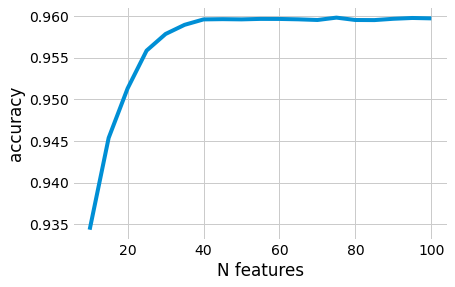

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

forest = RandomForestClassifier(bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)
# Select the top 100 features
sfm = SelectFromModel(forest, threshold=-np.inf, max_features=100)
X_sfm = sfm.fit_transform(X_smote, y_smote)
# Test different numbers of features from 50 to 100
print(f"{X_smote.shape[1]} features: {sfm.estimator_.oob_score_:.2%}")
sfm_scores = []
for i in range(95, 0, -5):
    sfm = SelectFromModel(forest, threshold=-np.inf, max_features=i)
    X_sfm = sfm.fit_transform(X_sfm, y_smote)
    sfm_scores.append(sfm.estimator_.oob_score_)
# Plot the results
plt.plot(np.arange(10, 105, 5), sfm_scores[::-1])
plt.xlabel("N features")
plt.ylabel("accuracy")
plt.show()

blabla

In [73]:
from sklearn.feature_selection import RFE

rfe = RFE(forest, n_features_to_select=40, step=5, verbose=1)
X_40 = rfe.fit_transform(X_smote, y_smote)
mask_40 = rfe.support_
forest.fit(X_40, y_smote)
print(f"{X_40.shape[1]} features: {forest.oob_score_:.2%}")


Fitting estimator with 171 features.
Fitting estimator with 166 features.
Fitting estimator with 161 features.
Fitting estimator with 156 features.
Fitting estimator with 151 features.
Fitting estimator with 146 features.
Fitting estimator with 141 features.
Fitting estimator with 136 features.
Fitting estimator with 131 features.
Fitting estimator with 126 features.
Fitting estimator with 121 features.
Fitting estimator with 116 features.
Fitting estimator with 111 features.
Fitting estimator with 106 features.
Fitting estimator with 101 features.
Fitting estimator with 96 features.
Fitting estimator with 91 features.
Fitting estimator with 86 features.
Fitting estimator with 81 features.
Fitting estimator with 76 features.
Fitting estimator with 71 features.
Fitting estimator with 66 features.
Fitting estimator with 61 features.
Fitting estimator with 56 features.
Fitting estimator with 51 features.
Fitting estimator with 46 features.
Fitting estimator with 41 features.
40 features: 

## Fine-Tune the hyperparameters

### Random Forest

In [94]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=42)
forest = RandomForestClassifier(random_state=42,
                                bootstrap=True,
                                n_jobs=-1)
param_grid = {'criterion': ['gini', 'entropy'],
              'max_features': np.arange(4, 13)}

grid_search = HalvingGridSearchCV(forest, param_grid, cv=cv,
                                  n_jobs=-1, verbose=1)
grid_search.fit(X_40, y_smote)
print(bay_search.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 62819
max_resources_: 565372
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 62819
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 6
n_resources: 188457
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 565371
Fitting 5 folds for each of 2 candidates, totalling 10 fits
OrderedDict([('criterion', 'gini'), ('max_features', 8)])


In [92]:
grid_search.best_score_

0.9881469531601805

In [82]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

forest = RandomForestClassifier(random_state=42,
                                bootstrap=True,
                                n_jobs=-1)
params = {'criterion': Categorical(['gini', 'entropy']),
          'max_features': Integer(5, 20, prior='uniform')}
cv = StratifiedKFold(5, shuffle=True, random_state=42)

bay_search = BayesSearchCV(forest, params, n_iter=10, n_jobs=2)
bay_search.fit(X_40, y_smote)
print(bay_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
OrderedDict([('criterion', 'gini'), ('max_features', 8)])


In [80]:
np.log2(40)

5.321928094887363

In [81]:
np.sqrt(40)

6.324555320336759

In [83]:
forest = RandomForestClassifier(criterion='gini',
                                max_features=8,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)
forest.fit(X_40, y_smote)
print(bay_search.best_params_)
print(f"{forest.oob_score_:.2%}")

OrderedDict([('criterion', 'gini'), ('max_features', 8)])
95.91%


In [84]:
forest = RandomForestClassifier(bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)
forest.fit(X_40, y_smote)
print(bay_search.best_params_)
print(f"{forest.oob_score_:.2%}")

OrderedDict([('criterion', 'gini'), ('max_features', 8)])
95.95%


In [87]:
forest = RandomForestClassifier(criterion='gini',
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)
forest.fit(X_40, y_smote)
print(bay_search.best_params_)
print(f"{forest.oob_score_:.2%}")

OrderedDict([('criterion', 'gini'), ('max_features', 8)])
95.95%


In [88]:
forest = RandomForestClassifier(criterion='gini',
                                max_features=6,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)
forest.fit(X_40, y_smote)
print(bay_search.best_params_)
print(f"{forest.oob_score_:.2%}")

OrderedDict([('criterion', 'gini'), ('max_features', 8)])
95.95%


In [89]:
forest.max_depth

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

forest = RandomForestClassifier(random_state=42,
                                bootstrap=True,
                                n_jobs=-1)
params = {'criterion': Categorical(['gini', 'entropy']),
          'max_features': Integer(5, 20, prior='uniform')}
cv = StratifiedKFold(5, shuffle=True, random_state=42)

bay_search = BayesSearchCV(forest, params, n_iter=10,
                           n_jobs=2, cv=cv,
                           verbose=1, random_state=42)
bay_search.fit(X_40, y_smote)
print(bay_search.best_params_)

## Analyse feature importance with SHAP

In [31]:
round(np.log2(X_smote.shape[0])/2, 0)

10.0